In [1]:
import findspark

findspark.init()

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [3]:
import pyspark
from pyspark.mllib.feature import HashingTF
# from pyspark.ml.feature import HashingTF, IDF ,Tokenizer
from pyspark.mllib.feature import IDF
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD, LogisticRegressionModel
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.feature import ChiSqSelector
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import os, tempfile
import csv
import string
import random
#import modules
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Tokenizer, StopWordsRemover

In [4]:
from pyspark import SparkContext
sc =SparkContext.getOrCreate()

In [5]:
# logFile = "file:///c:/Users/fazal/Desktop/Uni/project/dataset/twitter-airline-sentiment/Tweets"  
df = spark.read.csv('file:///c:/Users/fazal/Desktop/Uni/project/dataset/twitter-airline-sentiment/Tweets.csv',header=True)

In [6]:
df.printSchema()
df_renamed=df.withColumnRenamed("airline_sentiment","sentiment")
df.printSchema()
df_renamed.show(5, truncate = False)
df1=df_renamed.select('sentiment','text')
df1.show(50)

root
 |-- tweet_id: string (nullable = true)
 |-- airline_sentiment: string (nullable = true)
 |-- airline_sentiment_confidence: string (nullable = true)
 |-- negativereason: string (nullable = true)
 |-- negativereason_confidence: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- airline_sentiment_gold: string (nullable = true)
 |-- name: string (nullable = true)
 |-- negativereason_gold: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- text: string (nullable = true)
 |-- tweet_coord: string (nullable = true)
 |-- tweet_created: string (nullable = true)
 |-- tweet_location: string (nullable = true)
 |-- user_timezone: string (nullable = true)

root
 |-- tweet_id: string (nullable = true)
 |-- airline_sentiment: string (nullable = true)
 |-- airline_sentiment_confidence: string (nullable = true)
 |-- negativereason: string (nullable = true)
 |-- negativereason_confidence: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- a

In [7]:
# only show tweets with neutral and positive and negative sentiment and remove the others
df_filtered=df1.filter((df1['sentiment']=='positive') | (df1['sentiment']=='negative')| (df1['sentiment']=='neutral') )
numTransactionEachSentiment = df_filtered.groupBy("sentiment").count()
numTransactionEachSentiment.show(5)
df_filtered.show(20)

+---------+-----+
|sentiment|count|
+---------+-----+
| positive| 2363|
|  neutral| 3099|
| negative| 9178|
+---------+-----+

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
|  neutral|@VirginAmerica Wh...|
| positive|@VirginAmerica pl...|
|  neutral|@VirginAmerica I ...|
| negative|"@VirginAmerica i...|
| negative|@VirginAmerica an...|
| negative|@VirginAmerica se...|
| positive|@VirginAmerica ye...|
|  neutral|@VirginAmerica Re...|
| positive|@virginamerica We...|
| positive|@VirginAmerica it...|
|  neutral|@VirginAmerica di...|
| positive|@VirginAmerica I ...|
| positive|@VirginAmerica Th...|
| positive|@VirginAmerica @v...|
| positive|@VirginAmerica Th...|
| negative|@VirginAmerica SF...|
| positive|@VirginAmerica So...|
| negative|@VirginAmerica  I...|
| positive|I ❤️ flying @Virg...|
| positive|@VirginAmerica yo...|
+---------+--------------------+
only showing top 20 rows



In [8]:
# drop duplicated data
df_dropped_duplicated=df_filtered.dropDuplicates()
df_dropped_duplicated.show(3)

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
| positive|@united just want...|
| negative|@united Thanks fo...|
| negative|@united Yo yo yo ...|
+---------+--------------------+
only showing top 3 rows



In [9]:
########## convert column to lower case in pyspark
from pyspark.sql.functions import lower, col
df_lower_case=df_dropped_duplicated.select("sentiment", (lower(col('text'))).alias('text'))
df_lower_case.show(5)
# df2=df_lower_case.select('sentiment',' lower(text)')
# df2.show(5)

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
| positive|@united just want...|
| negative|@united thanks fo...|
| negative|@united yo yo yo ...|
| negative|@united day 3 of ...|
|  neutral|“@united: @rikrik...|
+---------+--------------------+
only showing top 5 rows



In [10]:
#divide data, 70% for training, 30% for testing
dividedData = df_lower_case.randomSplit([0.05, 0.01,0.94]) 
trainingData = dividedData[0] #index 0 = data training
testingData = dividedData[1] #index 1 = data testing
extraForNow = dividedData[2] #index 1 = data testing
train_rows = trainingData.count()
test_rows = testingData.count()
print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)

Training data rows: 746 ; Testing data rows: 142


In [11]:
#seperate words
tokenizer = Tokenizer(inputCol="text", outputCol="SentimentWords")
tokenizedTrain = tokenizer.transform(trainingData)
tokenizedTest = tokenizer.transform(testingData)
tokenizedTrain.show(truncate=False, n=5)
tokenizedTest.show(truncate=False, n=5)

+---------+-------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentiment|text                                                                                                                                       |SentimentWords                                                                                                                                                      |
+---------+-------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|negative |@united 777 from sfo to hnl with zero 

In [12]:
# Removing Stop words
def remove_values_from_list(the_list, val):
#     print(val)
#     if(val == 'i'):
#         return [value for value in the_list if value != 'i']
    return [value for value in the_list if value != val and value != 'i']

#clean data and remove stop words
stop=['i','me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']
row=tokenizedTrain.first()
# print(row.SentimentWords[0][5])
# for i in range(0,len(row.SentimentWords)):
#     print(row.SentimentWords[i])
import pyspark.sql.functions as F
from pyspark.sql.types import *
def cleanText(SentimentWords):
    s=SentimentWords
    for w in range(0,len(SentimentWords)):
#         s[i]='a'
        if('@' in SentimentWords[w]):
            s[w]='AT_USER'
        if('www.' in SentimentWords[w]):
            s[w]='URL'
        if('http://' in SentimentWords[w]):
            s[w]='URL'
        if('https://' in SentimentWords[w]):
            s[w]='URL'
        for i in range(0,len(SentimentWords[w])):
            flag=0
            if len(SentimentWords[w])>i+2 and SentimentWords[w][i]==SentimentWords[w][i+1] and SentimentWords[w][i]==SentimentWords[w][i+2]:
                for j in range(i+2,len(SentimentWords[w])):
                    if SentimentWords[w][i]==SentimentWords[w][j]:
                        flag=1
                        if len(SentimentWords[w])>j+1 and SentimentWords[w][i]!=SentimentWords[w][j+1]:
                            break
                    if j==(len(SentimentWords[w]))-1 and SentimentWords[w][i]==SentimentWords[w][j]:
                        flag=1
                        break
                if flag==1:
                    s[w]=SentimentWords[w].replace(SentimentWords[w][i:j+1],SentimentWords[w][i])
        if (SentimentWords[w]!='' and SentimentWords[w][0].isdigit()):
            s[w]=''
            
#     s=[]      
#     s.append('c')
    for i in range(0,len(stop)):
        if stop[i] in SentimentWords:
#             s.append(stop[i])
            s = remove_values_from_list(s, stop[i])
    s=[word.strip(string.punctuation) for word in s]
    while '' in s:
        s.remove('')
    return s
    
    
#convert to a UDF Function by passing in the function and return type of function
cleanTextUDF = F.udf(cleanText,ArrayType(StringType()))
trainCleaned = tokenizedTrain.withColumn("SentimentWordsCleaned", cleanTextUDF('SentimentWords'))
testCleaned = tokenizedTest.withColumn("SentimentWordsCleaned", cleanTextUDF('SentimentWords'))
# p=trainCleaned.randomSplit(weights=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], seed=1)
# CasesWithHighLow=CasesWithHighLow.sample(frac=1).reset_index(drop=True)
trainCleaned.show(10)
testCleaned.show(10)

+---------+--------------------+--------------------+---------------------+
|sentiment|                text|      SentimentWords|SentimentWordsCleaned|
+---------+--------------------+--------------------+---------------------+
| negative|@united 777 from ...|[@united, 777, fr...| [AT_USER, sfo, hn...|
| negative|@usairways flight...|[@usairways, flig...| [AT_USER, flight,...|
| negative|@united you had u...|[@united, you, ha...| [AT_USER, us, reb...|
|  neutral|@united i have a ...|[@united, i, have...| [AT_USER, lh, ret...|
| positive|@jetblue flight b...|[@jetblue, flight...| [AT_USER, flight,...|
|  neutral|@united i have re...|[@united, i, have...| [AT_USER, request...|
| positive|@southwestair you...|[@southwestair, y...| [AT_USER, know, w...|
| negative|@virginamerica sh...|[@virginamerica, ...| [AT_USER, shame, ...|
|  neutral|@united for our b...|[@united, for, ou...| [AT_USER, birthda...|
| negative|"@southwestair co...|["@southwestair, ...| [AT_USER, cool, p...|
+---------+-

In [13]:
from pyspark.sql import functions as f
trainCleaned_labelAdded=trainCleaned.withColumn('label', f.when(f.col('sentiment') == "negative", 0).otherwise(when(f.col('sentiment') == "positive", 2).otherwise(1)))
testCleaned_labelAdded=testCleaned.withColumn('label', f.when(f.col('sentiment') == "negative", 0).otherwise(when(f.col('sentiment') == "positive", 2).otherwise(1)))
trainCleaned_labelAdded.show(5)
testCleaned_labelAdded.show(5)

+---------+--------------------+--------------------+---------------------+-----+
|sentiment|                text|      SentimentWords|SentimentWordsCleaned|label|
+---------+--------------------+--------------------+---------------------+-----+
| negative|@united 777 from ...|[@united, 777, fr...| [AT_USER, sfo, hn...|    0|
| negative|@usairways flight...|[@usairways, flig...| [AT_USER, flight,...|    0|
| negative|@united you had u...|[@united, you, ha...| [AT_USER, us, reb...|    0|
|  neutral|@united i have a ...|[@united, i, have...| [AT_USER, lh, ret...|    1|
| positive|@jetblue flight b...|[@jetblue, flight...| [AT_USER, flight,...|    2|
+---------+--------------------+--------------------+---------------------+-----+
only showing top 5 rows

+---------+--------------------+--------------------+---------------------+-----+
|sentiment|                text|      SentimentWords|SentimentWordsCleaned|label|
+---------+--------------------+--------------------+--------------------

In [14]:
# #Compute TF
# def CompTF(tshuffle_rdd):
#     hashingTF = HashingTF(inputCol="SentimentWordsCleaned", outputCol="rawFeatures", numFeatures=25000)
#     featurizedData = hashingTF.transform(tshuffle_rdd)
#     return featurizedData
# #     return tf

# def CompTF_withNumFeatures(tshuffle_rdd):
#     hashingTF = HashingTF(inputCol="SentimentWordsCleaned", outputCol="rawFeatures", numFeatures=25000)
#     featurizedData = hashingTF.transform(tshuffle_rdd)
#     return featurizedData
# #     return tf

# #Compute IDF
# def CompIDF(tf):
#     tf.cache()
#     idf = IDF(inputCol="rawFeatures", outputCol="features")
#     idfModel = idf.fit(tf)
#     return idfModel

# #Compute TFIDF
# def CompTFIDF(tf,idf):
# #     tfidf = idf.transform(tf)
#     rescaledData = idf.transform(tf)
#     return rescaledData

# #Accuracy of Training data using train.csv itself using NB
# tf_train=CompTF(trainCleaned)
# idf_train=CompIDF(tf_train)
# tfidf_train=CompTFIDF(tf_train,idf_train)
# tfidf_train.show(10)


#Compute TF
def CompTF(tshuffle_rdd):
    t_rdd=sc.parallelize([row[3] for row in tshuffle_rdd.collect()])
    hashingTF = HashingTF(25000)
    tf = hashingTF.transform(t_rdd)
    return tf

def CompTF_withNumFeatures(tshuffle_rdd):
    t_rdd=sc.parallelize([row[3] for row in tshuffle_rdd.collect()])
    hashingTF = HashingTF(1500)
    tf = hashingTF.transform(t_rdd)
    return tf

#Compute IDF
def CompIDF(tf):
    tf.cache()
    idf = IDF().fit(tf)
    return idf

#Compute TFIDF
def CompTFIDF(tf,idf):
    tfidf = idf.transform(tf)
    return tfidf

#Accuracy of Training data using train.csv itself using NB
rdd_train = trainCleaned_labelAdded.rdd.map(list)
rdd_test = testCleaned_labelAdded.rdd.map(list)
tf_train=CompTF(rdd_train)
idf_train=CompIDF(tf_train)
tfidf_train=CompTFIDF(tf_train,idf_train)
print(tfidf_train.first())

(25000,[4836,5093,7191,8792,12124,19458],[5.517452896464707,0.0,5.229770824012927,4.670155036077504,5.922918004572872,4.824305715904762])


In [15]:
#Feature Extraction
def Convert_to_LabeledPoint(labels,features):
    training = labels.zip(features).map(lambda x: LabeledPoint(x[0], x[1]))
#     training = labels.zip(features)
    return training

#Feature Extraction for training (train.csv) dataset
# rdd = trainCleaned.rdd.map(list)
# tfidf_train_rdd = tfidf_train.rdd.map(list)
training_NB = Convert_to_LabeledPoint(sc.parallelize([row[4] for row in rdd_train.collect()]),tfidf_train)
print(training_NB.first())

# from pyspark.sql import functions as f
# training_NB=tfidf_train.withColumn('label', f.when(f.col('sentiment') == "negative", 0).otherwise(f.when(f.col('sentiment') == "positive", 2).otherwise(1)))
# training_NB.show(5)

(0.0,(25000,[4836,5093,7191,8792,12124,19458],[5.517452896464707,0.0,5.229770824012927,4.670155036077504,5.922918004572872,4.824305715904762]))


In [16]:
#Training - NB
def NB_train(training):
    model = NaiveBayes.train(training,1.0)
    return model

#training accuracy for NB ML technique - training with training data
model_train_NB=NB_train(training_NB)
# print(rdd_train.first())

In [17]:
#Testing

def test(model,labels,features):
    labels_and_preds = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "predicted": float(x[1])})
    acc=100.0*((labels_and_preds.filter(lambda x:x["actual"]==x["predicted"]).count()) / (labels.count()))
    return acc

#testing NB with training data 

accuracy_NB=test(model_train_NB,sc.parallelize([row[4] for row in rdd_train.collect()]),tfidf_train)

print ("TRAINING ACCURACY:-\n")

print("The accuracy for the training dataset tested on the training data itself using NB is",accuracy_NB,"%")

print ("\n")

TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using NB is 93.96782841823055 %




In [19]:
# KFold NB

print ("10-FOLD CV ACCURACIES FOR ALL ITERATIONS\n")

p=rdd_train.randomSplit(weights=[0.5, 0.5], seed=1)

tot_NB_kfold=0
NB_kfold_set=[]
for i in range(0,len(p)):
    test_RDD=p[i]
    train_tempRDD=sc.emptyRDD()
    for j in range(0,len(p)):
        if i!=j:
            train_tempRDD=train_tempRDD.union(p[j])
    tf_train=CompTF(train_tempRDD)
    idf_train=CompIDF(tf_train)
    tfidf_train=CompTFIDF(tf_train,idf_train)
    training = Convert_to_LabeledPoint(sc.parallelize([row[4] for row in train_tempRDD.collect()]),tfidf_train)
    model_train=NB_train(training)
    tf_test=CompTF(test_RDD)
    tfidf_test=CompTFIDF(tf_test,idf_train)
    accuracy=test(model_train,sc.parallelize([row[4] for row in test_RDD.collect()]),tfidf_test)
    print ("The accuracy for number",i+1,"kth partition test for 10-fold cross validation for NB is",accuracy,"%")
    NB_kfold_set.append(accuracy)
    tot_NB_kfold=tot_NB_kfold+accuracy
avg_NB_kfold=tot_NB_kfold/len(p)
# NB_kfold_best=max(NB_kfold_set)
print ("\n")
print ("The average accuracy for NB after 10-fold cross validation is",avg_NB_kfold,"%")
print ("\n")
# print ("The highest accuracy for NB after 10-fold cross validation is",NB_kfold_best,"%")
# print ("\n")

10-FOLD CV ACCURACIES FOR ALL ITERATIONS

The accuracy for number 1 kth partition test for 10-fold cross validation for NB is 66.29834254143645 %
The accuracy for number 2 kth partition test for 10-fold cross validation for NB is 64.0625 %


The average accuracy for NB after 10-fold cross validation is 65.18042127071823 %




In [20]:
#print (test_shuffle)
# tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF(rdd_test)
tf_train=CompTF(rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)


TEST ACCURACY:-

The accuracy of prediction for NB on testing data is 72.53521126760563 %


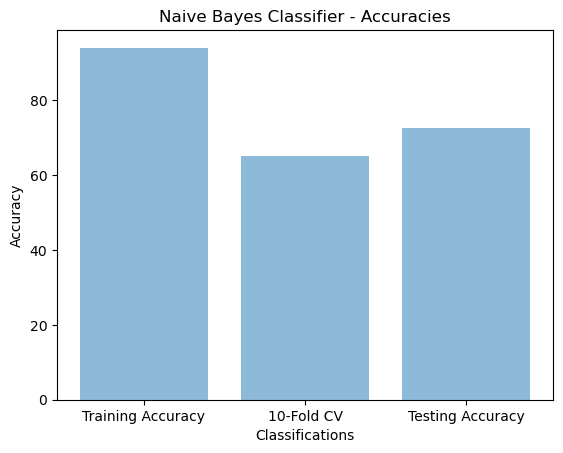

In [21]:
#Final Test

def test_final(model,labels,features):
    labels_and_preds = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "predicted": float(x[1])})
    acc=100.0*((labels_and_preds.filter(lambda x:x["actual"]==x["predicted"]).count()) / (labels.count()))
    return (labels_and_preds,acc)



labels_and_preds_NB,accu_NB = test_final(model_train_NB,sc.parallelize([row[4] for row in rdd_test.collect()]),tfidf_test)
metrics2 = BinaryClassificationMetrics(labels_and_preds_NB.map(lambda x: (x["predicted"], x["actual"])))
print ("\nTEST ACCURACY:-\n")
print("The accuracy of prediction for NB on testing data is",accu_NB,"%")
objects = ('Training Accuracy', '10-Fold CV', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_NB,avg_NB_kfold,accu_NB]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Classifier - Accuracies')
 
plt.show()

metrics = MulticlassMetrics(labels_and_preds_NB.map(lambda x: (x["predicted"], x["actual"])))

In [23]:
# Overall statistics
print("\nSummary Stats_NB\n")
# Statistics by class
labels = (sc.parallelize([row[4] for row in rdd_test.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_NB = %s" % (label, metrics.precision(label)))
    print("Class %s recall_NB = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_NB = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\nAvg/Weighted recall_NB = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_NB = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_NB = %s" % metrics.weightedFMeasure())

cm=metrics.confusionMatrix().toArray()
print("\nConfusion matrix_NB=")
print(cm)
print("\n")
metrics2 = BinaryClassificationMetrics(labels_and_preds_NB.map(lambda x: (x["predicted"], x["actual"])))

# Area under ROC curve
print("Area under ROC_NB = %s" % metrics2.areaUnderROC)


Summary Stats_NB

Class 0 precision_NB = 0.7459016393442623
Class 0 recall_NB = 0.9578947368421052
Class 0 F1 Measure_NB = 0.8387096774193549
Class 1 precision_NB = 0.7142857142857143
Class 1 recall_NB = 0.3225806451612903
Class 1 F1 Measure_NB = 0.4444444444444444
Class 2 precision_NB = 0.3333333333333333
Class 2 recall_NB = 0.125
Class 2 F1 Measure_NB = 0.18181818181818182

Avg/Weighted recall_NB = 0.7253521126760564
Avg/Weighted precision_NB = 0.6925130015063056
Avg/Weighted F(1) Score_NB = 0.6786217467725874

Confusion matrix_NB=
[[91.  3.  1.]
 [18. 10.  3.]
 [13.  1.  2.]]


Area under ROC_NB = 0.6496080627099664
